## Report 泰坦尼克号乘客获救情况分析

### 背景

1912年4月10日，号称“世界工业史上的奇迹”的豪华客轮Titanic号在自己的处女航行中与一座冰山相撞，这场海难被认为是20世纪人间十大灾难之一。电影中留下了经典的“You jump，I jump”。
豪华客轮倒了，大家都惊恐逃生，可是救生艇的数量有限，副船长说”lady and kid first“。所以是否获救其实并非随机，而是基于一些背景有排序先后的。本项目旨在简单解析获救规律，找出生还率最高的乘客特征。

### 目的
本项目主要解答以下疑问：

1.在Titanic事件中，男性和女性的获救情况分别是怎样的？女性是否有更多生还机会？<br>
2.当时乘客的年龄分布是怎样的？哪些年龄段的人获救比例最高？<br>
3.不同客舱等级的乘客获救情况是怎样的<br>
4.综合考虑多个因素，什么样的人，在Titanic事件中获救的可能性最高呢？<br>


### 数据预处理

在这个项目中，数据是从Kaggle网站上获取的CSV数据，数据本身相对完整，不需要再进行数据采集。

In [1]:
# 导入数据分析的常用的包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 可视化中显示中文黑体，显示负数
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [2]:
# 加载csv数据
data = pd.read_csv('titanic.csv')
# 查看数据前5行
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


数据字段<br>
PassengerId => 乘客ID<br>
Survived =>是否获救<br>
Pclass => 乘客等级(1/2/3等舱位)<br>
Name => 乘客姓名<br>
Sex => 性别<br>
Age => 年龄<br>
SibSp => 堂兄弟/妹个数<br>
Parch => 父母与小孩个数<br>
Ticket => 船票信息<br>
Fare => 票价<br>
Cabin => 客舱<br>
Embarked => 登船港口<br>

In [3]:
# 查看数据属性
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


数据中总共有891名乘客。<br>
Age、Cabin和Embarked部分数据有缺失:<br>
Age（年龄）属性只有714名乘客有记录，<br>
Cabin（客舱）更是只有204名乘客是已知的，<br>
Embarked缺失2条数据。<br>
可以通过人工补全（比如将缺失值设为众数或者平均数,也可以直接去掉那一行），但是Cabin的有效数据缺失较为严重，考虑其对分析的作用较小，本次不做分析。


In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


用描述统计得到数值型数据的一些分布(因为有些属性，比如姓名，是文本型；而另外一些属性，比如登船港口，是类目型。这些我们用描述统计是看不到的)<br>
mean字段告诉我们，只有38.38%的人最后获救了，2/3等舱的人数比1等舱要多，平均乘客年龄大概是29.7岁。

In [5]:
data['Embarked'].mode()

0    S
dtype: object

In [6]:
# 用平均数对Age补全
data['Age'] = data['Age'].fillna(data['Age'].mean())
# 用众数对Embarked补全
data['Embarked'] = data['Embarked'].fillna("S")

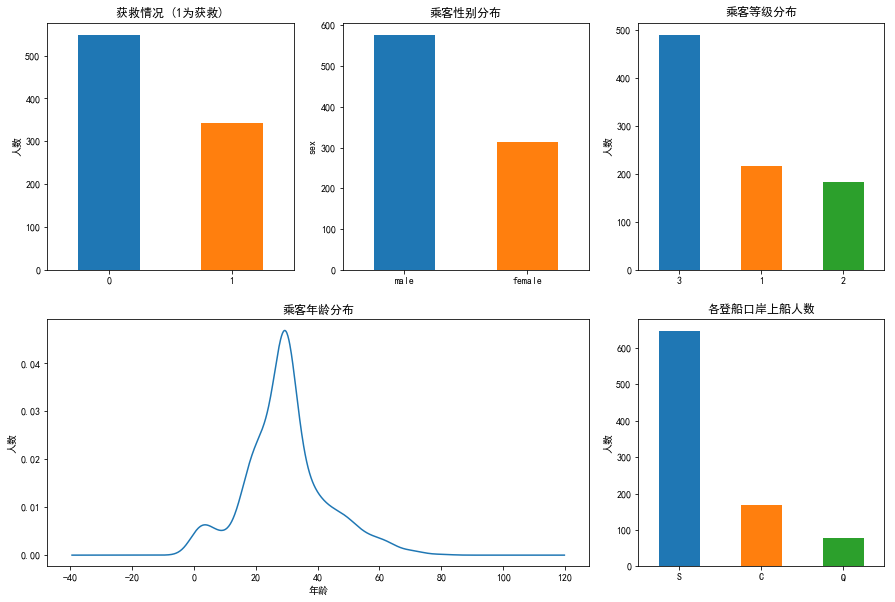

In [7]:
# 画出Survived,sex,Pclass,Age,Embarked分布图，更进一步的了解数据集的情况：
fig = plt.figure( figsize =(15,10))
fig.set(alpha=0.2)  # 设定图表颜色alpha参数
#获救情况柱形图
plt.subplot2grid((2,3),(0,0))  #设置子图     
data.Survived.value_counts().plot(kind='bar')
plt.title('获救情况 (1为获救)') 
plt.xticks(rotation = 0)  #x轴刻度显示无倾斜
plt.ylabel('人数')  
#乘客性别分布柱形图
plt.subplot2grid((2,3),(0,1))
data.Sex.value_counts().plot(kind='bar')
plt.ylabel('sex')                         
plt.xticks(rotation = 0)
plt.title('乘客性别分布')
#乘客等级分布柱形图
plt.subplot2grid((2,3),(0,2))
data.Pclass.value_counts().plot(kind="bar")
plt.xticks(rotation = 0)
plt.ylabel('人数')
plt.title('乘客等级分布')
#乘客年龄分布图
plt.subplot2grid((2,3),(1,0), colspan=2)
data.Age.plot(kind="kde")  
plt.xlabel('年龄')
plt.ylabel('人数') 
plt.title('乘客年龄分布')
#各口岸登船人数柱形图
plt.subplot2grid((2,3),(1,2))
data.Embarked.value_counts().plot(kind='bar')
plt.title('各登船口岸上船人数')
plt.xticks(rotation = 0)
plt.ylabel('人数')  
plt.show()


- 被救的人300多，不到半数；<br>
- 女性乘客300多人；<br>
- 3等舱乘客占到一半以上；<br>
- 乘客年龄主要集中在20岁到40岁，30岁左右的乘客最多；<br>
- 登船港口人数按照S、C、Q递减，而且S远多于另外俩港口。

### 数据分析

**1.男性和女性的获救情况**

<Figure size 432x288 with 0 Axes>

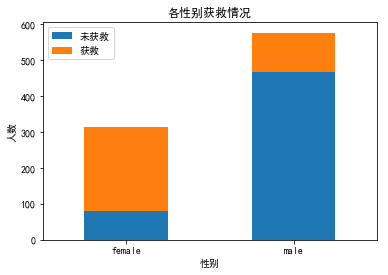

In [8]:
#各性别的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数
data.groupby(['Survived','Sex'])['PassengerId'].count().unstack(level = 'Survived').plot.bar(stacked=True)
plt.title('各性别获救情况')
plt.xticks(rotation = 0)
plt.xlabel('性别') 
plt.ylabel('人数')
plt.legend(('未获救','获救'),loc='best')
plt.show()

女性获救人数远远高于男性！女性获救比例约为74%，男性获救比例约为19%。无论从获救人数还是从获救比例来看，女性的生还率都远远高于男性。<br>
由此，在仅考虑性别这一因素的情况下，我们大致可以推断： 在Titanic事件中，**‘lady first’这一道德准则被坚定的执行了，乘员中的女性获得了更多的生还机会。**

In [9]:
# 计算各性别生还率
survived_rate_by_sex = (data.groupby(['Sex'])['Survived'].sum() / data.groupby(['Sex'])['Survived'].count()).round(2)
survived_rate_by_sex

Sex
female    0.74
male      0.19
Name: Survived, dtype: float64

**2.各年龄获救情况**

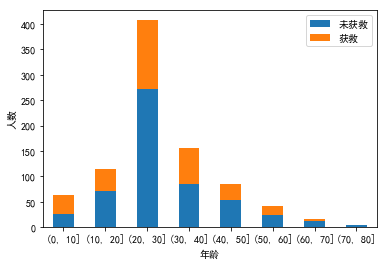

In [10]:
# 将年龄按照整十进行分组，不同年龄段获救人数
data['Grouped_Age'] = pd.cut(data['Age'],np.arange(0,100,10))
survived_age = data.groupby(['Grouped_Age','Survived'])['Survived'].count().unstack()
survived_age.plot(kind='bar',stacked=True)
plt.xlabel('年龄')
plt.ylabel('人数')
plt.xticks(rotation = 0)
plt.legend(('未获救','获救'),loc='best')
plt.show()

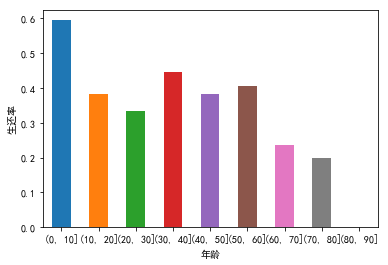

In [11]:
# 不同年龄段生还率
data.groupby('Grouped_Age')['Survived'].mean().plot(kind='bar')
plt.xticks(rotation = 0)
plt.xlabel('年龄')
plt.ylabel('生还率')
plt.show()

70-80岁、80-90岁两个年龄段由于人数较少，因此可以认为这两个年龄段我们计算出的生还率不具备显著的统计意义，暂不考虑。<br>
排除上述两个年龄段后可以得出：<br>
1.20-30岁这个年龄段获救人数最多，但也是因为20-30岁人数基数最大；<br>
2.0-10岁这个年龄段（即儿童）的生还率最高，接近60%；<br>
3.60-70岁（老年人）的生还率最低，只有25%左右；<br>
4.青壮年（10-60）人群的生还率在35%-45%之间，其中生还率最低的是20-30岁人群，只有35%左右。<br>
上面这些结论其实非常有趣。一般来讲，由于生理上的差异，在面对灾难时，青壮年人群的生还率要显著高于儿童和老人。但是我们可以看到在Titanic沉船事件中却并非如此。<br>
60-70岁的老人生还率确实比较低，这个有两方面的因素可以解释，一是因为这个年龄段的老人生理上处于衰弱期，可能还伴有疾病，因此即便获得了逃生的机会也不一定能够幸存；二是在数据集中这个年龄段人数只有19人，基数偏小，因此计算得出的生还率受随机因素影响较大，代表性不强。<br>
对于0-10岁的儿童，我们可以看到生还率远远高于其他年龄段，但是儿童显然不具备很高的自救能力。因此我们可以大胆的推断：在Titanic沉船事件的逃生过程中，儿童得到了优待明显的优待，因此其生还率显著高于其他年龄段。<br>


**3.各等级舱的获救情况**

<Figure size 432x432 with 0 Axes>

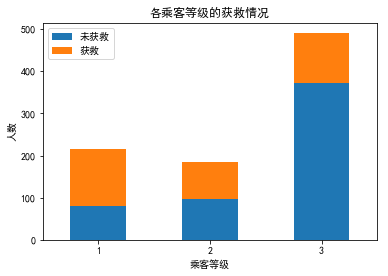

In [12]:
#各乘客等级的获救情况
fig = plt.figure(figsize = (6,6))
fig.set(alpha=0.2)  # 设定图表颜色alpha参数
data.groupby(['Survived','Pclass'])['PassengerId'].count().unstack(level = 'Survived').plot.bar(stacked=True)
plt.title('各乘客等级的获救情况')
plt.xticks(rotation = 0)
plt.xlabel('乘客等级') 
plt.ylabel('人数') 
plt.legend(('未获救','获救'),loc='best')
plt.show()

数据集中三等舱人数最多，其次是一等舱，二等舱最少；<br>
一等舱生还人数最多，其次是三等舱，二等舱最少；<br>
一等舱生还比例最高，二等舱次之，三等舱最低。<br>
这是非常明显的阶梯型的差异，一等舱乘客的生还率远高于三等舱，是两倍还多。<br>
考虑到舱位等级背后隐含的贫富的差异，我们大概可以推断：在Titanic沉船事件中，相对富有的人（一等舱乘客）生还率远高于相对贫穷的人（三等舱乘客）。

**4.综合考虑多个因素，分析哪个人群生还几率最高**

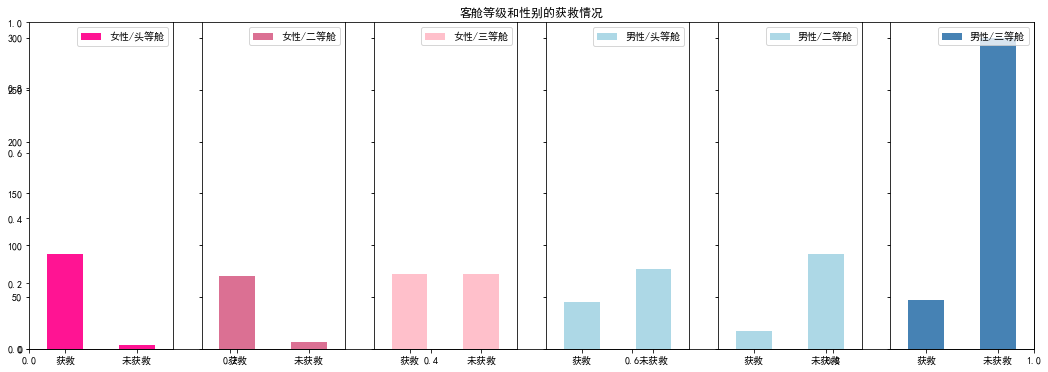

In [13]:
# 各种舱级别情况下各性别的获救情况
fig=plt.figure(figsize = (18,6))
fig.set(alpha=0.65) 
plt.title('客舱等级和性别的获救情况')

ax1=fig.add_subplot(161)
data.Survived[data.Sex == 'female'][data.Pclass == 1].value_counts().plot(kind='bar', label="female high class", color='deeppink')
ax1.set_xticklabels(['获救','未获救'], rotation=0)
ax1.legend(['女性/头等舱'], loc='best')

ax2=fig.add_subplot(162, sharey=ax1)
data.Survived[data.Sex == 'female'][data.Pclass == 2].value_counts().plot(kind='bar', label='female, middle class', color='palevioletred')
ax2.set_xticklabels(['获救', '未获救'], rotation=0)
plt.legend(['女性/二等舱'], loc='best')

ax3=fig.add_subplot(163, sharey=ax1)
data.Survived[data.Sex == 'female'][data.Pclass == 3].value_counts().plot(kind='bar', label='female, low class', color='pink')
ax3.set_xticklabels(['获救', '未获救'], rotation=0)
plt.legend(['女性/三等舱'], loc='best')

ax4=fig.add_subplot(164, sharey=ax1)
data.Survived[data.Sex == 'male'][data.Pclass == 1].value_counts().sort_values().plot(kind='bar', label='male, high class',color='lightblue')
ax4.set_xticklabels(['获救', '未获救'], rotation=0)
plt.legend(['男性/头等舱'], loc='best')

ax5=fig.add_subplot(165, sharey=ax1)
data.Survived[data.Sex == 'male'][data.Pclass == 2].value_counts().sort_values().plot(kind='bar', label='male, high class',color='lightblue')
ax5.set_xticklabels(['获救', '未获救'], rotation=0)
plt.legend(['男性/二等舱'], loc='best')

ax6=fig.add_subplot(166, sharey=ax1)
data.Survived[data.Sex == 'male'][data.Pclass == 3].value_counts().sort_values().plot(kind='bar', label='male low class', color='steelblue')
ax6.set_xticklabels(['获救', '未获救'], rotation=0)
plt.legend(['男性/三等舱'], loc='best')

plt.show()

头等舱和二等舱的女性获救比例非常高，三等舱女性获救比例为50%。<br>
头等舱男性获救比例高于二等舱和三等舱。<br>
也验证了之前提到的女性/头等舱乘客生还率较高。

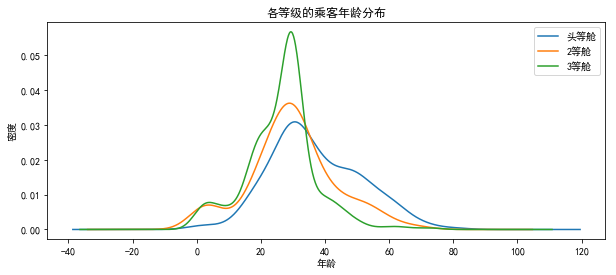

In [14]:
# 各等级乘客的年龄分布
plt.figure(figsize = (10,4))
data.Age[data.Pclass == 1].plot(kind='kde') 
data.Age[data.Pclass == 2].plot(kind='kde')
data.Age[data.Pclass == 3].plot(kind='kde')
plt.xlabel('年龄')
plt.ylabel('密度') 
plt.title('各等级的乘客年龄分布')
plt.legend(('头等舱','2等舱','3等舱'),loc='best')
plt.show()

3个等级的舱年龄总体趋势基本一致，乘客年龄做多在30岁左右，头等舱40-50岁的乘客比二等、三等舱比例更高。

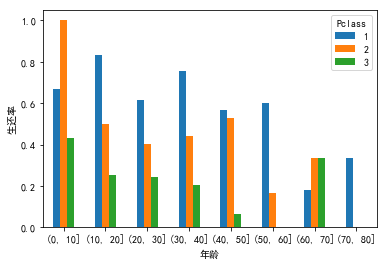

In [15]:
# 各乘客等级下各年龄段生还率
data.groupby(['Grouped_Age','Pclass'])['Survived'].mean().unstack(level = 'Pclass').plot(kind='bar')
plt.xticks(rotation = 0)
plt.xlabel('年龄')
plt.ylabel('生还率')
plt.show()

从上图可以看出：<br>
头等舱除了60-70岁年龄段以外，其余年龄段生还率都较高，在60%-85%之间；<br>
二等舱0-10岁年龄段全部获救，10-50岁年龄段生还率在40%-60%之间；<br>
而三等舱仅0-10岁年龄段生还率超过了40%.

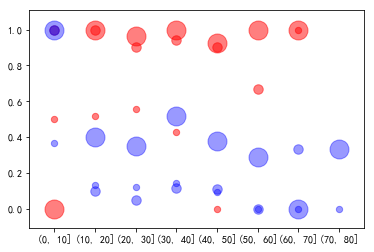

In [16]:
# 按照性别、舱位、年龄段进行多层分组
grouped = data.groupby(['Sex','Pclass','Grouped_Age']).count()
survived = data.groupby(['Sex','Pclass','Grouped_Age']).sum()
survived_rate = (survived['Survived'].apply(float) / grouped['Survived'].apply(float))
grouped['SurvivedRate'] = survived_rate
grouped_sex = grouped['SurvivedRate'].unstack(0)
female_data = grouped_sex.female.unstack()
male_data = grouped_sex.male.unstack()

#绘制气泡图
x1 = range(len(female_data.columns))
for i in female_data.index:
    y = female_data.loc[i].values
    plt.scatter(x1,y,s = 360/(i*i),color = 'r', alpha = 0.5)
    plt.xticks(x1,female_data.columns)
    
x2 = range(len(male_data.columns))
for i in male_data.index:
    y = male_data.loc[i].values
    plt.scatter(x2,y, s = 360/(i*i), color = 'b', alpha = 0.4)


上面的气泡图中，横坐标代表年龄段分布，纵坐标代表乘客生还率。红色的气泡代表女性乘员，蓝色代表男性乘员。大的气泡代表一等舱，中等气泡代表二等舱，最小的气泡代表三等舱。 从图中可以看到：<br>
- 从10岁直到70岁这个年龄段，几乎所有舱位的女性乘客生还率都高于男性乘员。
- 一等舱和二等舱的女性乘客，只要年龄超过10岁，其生还率基本都在85%以上。<br>
**综合上面的分析可以得出生还率最高的人群为：女性，年龄在10-70岁之间，乘坐一等舱或二等舱。其生还率在85%以上。**



### 分析总结

本次项目使用pandas库对数据进行了整理和计算，并使用matplotlib库将数据可视化。通过对数据的计算和对图形的观察，得出生还率最高的人群特征为：女性，年龄在10-70岁之间，乘坐一等舱或二等舱。本次分析仅初步探索了Titanic号沉船事件中，影响生还率的部分因素，并未进行深入的挖掘。待以后有时间，还可以搭建一些机器学习的模型，通过数据训练，来预测未给出数据的乘客生还情况。